# Find worst cases 

\begin{equation}
\begin{array}{rl}
    \mathcal{F}_L =& \dfrac{4 K I H r}{Q_{in}(1+f)}\\
    u_{c} =& \dfrac{-KI\mathcal{F}_L}{\theta \left(\mathcal{F}_L+1\right)}\\
    \tau =& -\dfrac{r}{|u_{c}|}\\
    C_{\tau,{\rm decay}}=& C_0 \exp{\left(-\lambda \tau \right)}\\
    C_{\tau,{\rm filtr}}=& C_0 \exp{\left(-k_{\rm att} \tau \right)}\\
    C_{\tau,{\rm dilut}} =& C_{in} \left( \dfrac{Q_{in}}{u_c \Delta y \Delta z} \right)\\
    C_{\tau,{\rm both}} =& \dfrac{C_{\rm in}Q_{\rm in}}{u_c \Delta y H \theta} \exp{\left(-\lambda\dfrac{r}{|u_c|}\right)}
\end{array}
\end{equation}

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from os import system
import os
from matplotlib.gridspec import GridSpec 
from drawStuff import *

import jupypft.attachmentRateCFT as CFT
import jupypft.plotBTC as BTC

''' GLOBAL CONSTANTS '''
PI = 3.141592
THETA = 0.35

In [2]:
def flowNumber():
    return (4.0*K*I*H*r) / (Qin*(1+f))

def uChar():
    '''Interstitial water velocity'''
    return -(K*I*flowNumber())/(THETA*(flowNumber() + 1))

def tChar():
    return -r/uChar()

def cDecay():
    return C0 * np.exp(-decayRate * tChar())

def cAttach():
    return C0 * np.exp(-attchRate * tChar())

def cDilut():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA)

def cBoth():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA) * np.exp(-decayRate * tChar())

def cTrice():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA) * np.exp(-(decayRate+attchRate) * tChar())

def findSweet():
    deltaConc = np.abs(cBoth() - np.max(cBoth()))
    return np.argmin(deltaConc)

In [3]:
K = 10**-2
Qin = 0.24/86400
f = 10
H = 20
r = 40
I = 0.001
C0 = 1.0
qabs = np.abs(uChar()*THETA)

kattDict = dict(
    dp = 1.0E-7,
    dc = 2.0E-3,
    q = qabs,
    theta = THETA,
    visco = 0.0008891,
    rho_f = 999.79,
    rho_p = 1050.0,
    A = 5.0E-21,
    T = 10. + 273.15,
    alpha = 0.01)

decayRate = 3.5353E-06
attchRate,_ = CFT.attachmentRate(**kattDict)
delY,delZ = 1.35,H

In [4]:
print("Nondim Flow  = {:.2E}".format(flowNumber()))
print("Charac. Vel  = {:.2E} m/s".format(uChar()))
print("Charac. time = {:.2E} s".format(tChar()))

Nondim Flow  = 1.05E+03
Charac. Vel  = -2.85E-05 m/s
Charac. time = 1.40E+06 s


In [5]:
print("Rel concenc. due decay = {:.2E}".format(cDecay()))
print("Rel conc. due dilution = {:.2E}".format(cDilut()))
print("Rel conc. due attachmt = {:.2E}".format(cAttach()))
print("Rel conc. due both eff = {:.2E}".format(cBoth()))
print("Rel conc. due three ef = {:.2E}".format(cTrice()))

Rel concenc. due decay = 7.05E-03
Rel conc. due dilution = 1.03E-02
Rel conc. due attachmt = 4.42E-05
Rel conc. due both eff = 7.26E-05
Rel conc. due three ef = 3.21E-09


# Plot v. 1

# v.2 With PFLOTRAN result

In [6]:
listOfFiles = os.listdir("LittleValidation_MASSBALANCES")
listOfFiles.sort()
    
IPFLO = [float(s[9:16]) for s in listOfFiles]
CPFLO = BTC.get_endConcentrations(
            "LittleValidation_MASSBALANCES",
            indices={'t':"Time [d]",\
                     'q':"ExtractWell Water Mass [kg/d]",\
                     'm':"ExtractWell Vaq [mol/d]"
                    },
            normalizeWith=dict(t=1.0,q=kattDict['rho_f']/1000.,m=1.0))

NumExpr defaulting to 8 threads.


In [7]:
listOfFiles = os.listdir("LittleValidation_MASSBALANCES_Att")
listOfFiles.sort()
    
IPFLO2 = [float(s[8:15]) for s in listOfFiles]
CPFLO2 = BTC.get_endConcentrations(
            "LittleValidation_MASSBALANCES_Att",
            indices={'t':"Time [d]",\
                     'q':"ExtractWell Water Mass [kg/d]",\
                     'm':"ExtractWell Vaq [mol/d]"
                    },
            normalizeWith=dict(t=1.0,q=kattDict['rho_f']/1000.,m=1.0))

In [8]:
# Theoretical stuff
I = 10**np.linspace(-5,0,num=100)
cDec = cDecay()
cDil = cDilut()
cAtt = cAttach()
cBot = cBoth()
cAll = cTrice()
i = findSweet()
worstC = cBot[i]
worstI = I[i]

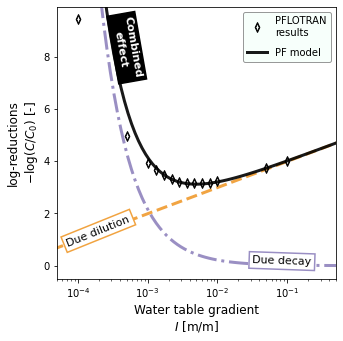

In [12]:
fig, axs = plt.subplots(1,1,figsize=(5,5)) 
fontdict = dict(size=12)
lines = {}
information = \
    r"$\bf{K} = $" + BTC.sci_notation(K) + " m/s\n"\
    r"$\bf{H}$" + " = {:.1f} m".format(H) + "\n"\
    r"$\bf{r}$" + " = {:.1f} m".format(r) + "\n"\
    r"$\bf{Q_{in}}$" + " = {:.2f} m³/d".format(Qin*86400) + "\n"\
    r"$\bf{f}$" + " = {:.1f}".format(f) + "\n"\
    r"$\bf{\lambda_{\rm aq}} = $" + BTC.sci_notation(decayRate) + " s⁻¹"\

####################################
# Ax2 - log-removals
ax = axs

lines['Dilution'] = ax.plot(I,-np.log10(cDil),\
        label="Due dilution",\
        lw=3,ls="dashed",alpha=0.99,c='#f1a340')
lines['Decay'] = ax.plot(I,-np.log10(cDec),\
        label="Due decay",\
        lw=3,ls="dashdot",alpha=0.99,c='#998ec3')
#ax.plot(I,-np.log10(cAtt),\
#        label="Due attachment " + symbols['att'],\
#        lw=2,ls="dashed",alpha=0.5,c='olive')
lines['Both'] = ax.plot(I,-np.log10(cBot),\
        label="Combined effect",\
        lw=3,c='k',alpha=0.9,zorder=2)
#ax.plot(I,-np.log10(cAll),\
#        label=symbols['dil'] + " + " + symbols['dec'] + " + " + symbols['att'],\
#        lw=2,c='gray',alpha=0.9,zorder=2)
lines['PFLOT'] = ax.plot(IPFLO,-np.log10(CPFLO),zorder=2,\
        label= "PFLOTRAN\nresults",\
        lw=0,ls='dotted',c='k',alpha=0.9,\
        marker="$\u25CA$",mec='k',mfc='k',ms=10)

ax.set(xscale="log")
ax.set(xlim=(5.0E-5,5.0E-1),ylim=(-0.5,9.9))
ax.set_xlabel("Water table gradient\n$I$ [m/m]",fontdict=fontdict)
ax.set_ylabel("log-reductions\n$-\log(C/C_0)$ [-]",fontdict=fontdict)

## Legend
whitebox = ax.scatter([1],[1],c="white",marker="o",s=1,alpha=0)

handles = [lines['PFLOT'][0],
           lines['Both'][0]]

labels = [lines['PFLOT'][0].get_label(),
          "PF model"]

plt.legend(handles, labels,
           loc="upper right",ncol=1,\
          edgecolor='gray',facecolor='mintcream',labelspacing=1)

##aNNOTATIONS
rotang = -2.0
bbox = dict(boxstyle='square', fc='w', ec='#998ec3',lw=1.5)
ax.text(0.7,0.05,'Due decay',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

rotang = 22.0
bbox = dict(boxstyle='square', fc='w', ec='#f1a340',lw=1.5)
ax.text(0.03,0.12,'Due dilution',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

rotang = -80.0
bbox = dict(boxstyle='square', fc='k', ec='k',lw=1.5)
ax.text(0.25,0.85,'Combined\neffect',c='w',ha='center',va='center',weight='bold',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

bbox = dict(boxstyle='round,pad=0.5,rounding_size=0.3', fc='whitesmoke', alpha=0.90,ec='whitesmoke')
#ax.text(0.60,0.64,information,bbox=bbox,transform=ax.transAxes,fontsize=10)

fig.savefig(fname="combinedTwoEffects.png",transparent=False,dpi=300)
#plt.show()

<ipython-input-14-7a8943d51a63>:23: RuntimeWarning: divide by zero encountered in log10
  lines['Attach'] = ax.plot(I,-np.log10(cAtt),\
<ipython-input-14-7a8943d51a63>:29: RuntimeWarning: divide by zero encountered in log10
  lines['Both'] = ax.plot(I,-np.log10(cAll),\


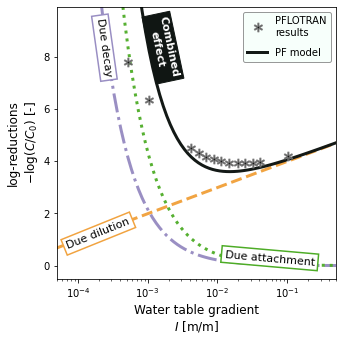

In [14]:
fig, axs = plt.subplots(1,1,figsize=(5,5)) 
fontdict = dict(size=12)
lines = {}
information = \
    r"$\bf{K} = $" + BTC.sci_notation(K) + " m/s\n"\
    r"$\bf{H}$" + " = {:.1f} m".format(H) + "\n"\
    r"$\bf{r}$" + " = {:.1f} m".format(r) + "\n"\
    r"$\bf{Q_{in}}$" + " = {:.2f} m³/d".format(Qin*86400) + "\n"\
    r"$\bf{f}$" + " = {:.1f}".format(f) + "\n"\
    r"$\bf{\lambda_{\rm aq}} = $" + BTC.sci_notation(decayRate) + " s⁻¹\n"\
    r"$\bf{k_{\rm att}} = $" + BTC.sci_notation(attchRate) + " s⁻¹"

####################################
# Ax2 - log-removals
ax = axs

lines['Dilution'] = ax.plot(I,-np.log10(cDil),\
        label="Due dilution",\
        lw=3,ls="dashed",alpha=0.99,c='#f1a340')
lines['Decay'] = ax.plot(I,-np.log10(cDec),\
        label="Due decay",\
        lw=3,ls="dashdot",alpha=0.99,c='#998ec3')
lines['Attach'] = ax.plot(I,-np.log10(cAtt),\
        label="Due attachment",\
        lw=3,ls="dotted",alpha=0.95,c='#4dac26')
#lines['Both'] = ax.plot(I,-np.log10(cBot),\
#        label="Combined effect",\
#        lw=3,c='k',alpha=0.9,zorder=2)
lines['Both'] = ax.plot(I,-np.log10(cAll),\
        label="Combined\neffect",\
        lw=3,c='#101613',alpha=0.99,zorder=2)

lines['PFLOT'] = ax.plot(IPFLO2,-np.log10(CPFLO2),zorder=2,\
        label= "PFLOTRAN\nresults",\
        lw=0,ls='dotted',c='k',alpha=0.9,\
        marker="$\u2217$",mec='gray',mfc='k',ms=10)

ax.set(xscale="log")
ax.set(xlim=(5.0E-5,5.0E-1),ylim=(-0.5,9.9))
ax.set_xlabel("Water table gradient\n$I$ [m/m]",fontdict=fontdict)
ax.set_ylabel("log-reductions\n$-\log(C/C_0)$ [-]",fontdict=fontdict)

## Legend
whitebox = ax.scatter([1],[1],c="white",marker="o",s=1,alpha=0)

handles = [lines['PFLOT'][0],
           lines['Both'][0]]

labels = [lines['PFLOT'][0].get_label(),
          "PF model"]

plt.legend(handles, labels,
           loc="upper right",ncol=1,\
          edgecolor='gray',facecolor='mintcream',labelspacing=1)

##aNNOTATIONS
rotang = -82.0
bbox = dict(boxstyle='square', fc='w', ec='#998ec3',lw=1.5)
ax.text(0.17,0.85,'Due decay',c='k',fontweight='normal',ha='center',va='center',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

rotang = 22.0
bbox = dict(boxstyle='square', fc='w', ec='#f1a340',lw=1.5)
ax.text(0.03,0.11,'Due dilution',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

rotang = -5.0
bbox = dict(boxstyle='square', fc='w', ec='#4dac26',ls='-',lw=1.5)
ax.text(0.60,0.05,'Due attachment',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

rotang = -78.0
bbox = dict(boxstyle='square', fc='#101613', ec='#101613')
ax.text(0.38,0.85,'Combined\neffect',c='w',ha='center',va='center',weight='bold',
         fontsize=11,rotation=rotang,bbox=bbox,transform=ax.transAxes)

bbox = dict(boxstyle='round,pad=0.5,rounding_size=0.3', fc='whitesmoke', alpha=0.90,ec='whitesmoke')
#ax.text(0.60,0.58,information,bbox=bbox,transform=ax.transAxes,fontsize=10)

fig.savefig(fname="combinedThreeEffects.png",transparent=False,dpi=300)
plt.show()

# v.3 Together as filtration is assumed

____
# Find the worst case 
## >> Geometric parameters $H$ and $r$

## >>Well parameters

## Hydraulic conductivity

## PLOTRAN SIMULATION RESULTS